# Importer les librairies

In [2]:
#Connecter Google Colab à Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Installer les librairies utiles
!pip install thefuzz[speedup]
!pip install fuzzy_pandas
!pip install texthero
!pip install -U scipy
!pip install TextStat
!pip install simpletransformers
!pip install pyyaml==5.4.1
!pip install pingouin
!pip install -U matplotlib
!pip install -U seaborn

In [13]:
#Importer les librairies utiles
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import cm
import matplotlib.patches as mpatches
import numpy as np
from datetime import datetime
from datetime import timedelta
from thefuzz import fuzz
from thefuzz import process
import fuzzy_pandas as fpd
import texthero as hero
from nltk.corpus import stopwords
from google.colab import drive
import textstat
from scipy import stats
import seaborn as sns
from simpletransformers.classification import ClassificationModel, ClassificationArgs
from sklearn.metrics import classification_report
import scipy.stats as stats
import pingouin as pg
from tqdm.notebook import tqdm
import itertools
import io

# Importer les fichiers

In [1]:
#Importer les fichiers de données
#articles repris (pouplaires) 
reprises_df = pd.read_csv("content/labelled_data.csv")

#Tout les articles écrits dans la période
nvlles_df = pd.read_csv("content/nvlles_df.csv")

#Métadonnées sur les articles
superdesk_df = pd.read_csv("content/articles_df_clean.csv")

# Transformation des fichiers

In [53]:
#Compter le nombre de mots uniques par articles et le nombre de mots totaux
def count_unique_words(text):
  column_list = text.str.lower().str.split()
  nb_unique = []
  nb_mots_list = []
  for list_words in column_list:
    unique = []
    nb_mots = 0
    for word in list_words:
      nb_mots+=1
      if word not in unique:
        unique.append(word)
    nb_unique.append(len(unique))
    nb_mots_list.append(nb_mots)

  return nb_unique, nb_mots_list

In [ ]:
#Nettoyage de données de "Nouvelles sur commandes"
def GetCleanNvl(df):
  #Enlever la colonne inutile
  df.drop(columns='Unnamed: 0', inplace=True)

  #Enlever les charactères spéciaux
  df = df.replace('\n','', regex=True)
  df = df.replace('\t','', regex=True)

  #Supprimer les différentes maj d'un même article
  df.sort_values(by=['date'], inplace=True)
  df = df.drop_duplicates(subset=['titre'], keep='last').reset_index()

  #Mettre les dates au bon format
  df['date'] = pd.to_datetime(df['date'])
  df['Jour'] = df['date'].dt.date
  df['Jour'] = df['Jour'].astype('datetime64[ns]')

  #Simplification des titres
  stopwords_fr = set(stopwords.words('french'))
  df['titre_full'] = df['titre']
  df['titre'] = hero.remove_stopwords(df['titre'].str.lower().str.strip(), stopwords_fr)
  df['titre'] = hero.remove_punctuation(df['titre'])
  df['titre'] = hero.remove_diacritics(df['titre'])

  #Simplification des textes
  df = df[df.texte.apply(isinstance,args=(str,))]
  df['texte_full'] = df['texte']
  df['texte'] = hero.remove_stopwords(df['texte'].str.lower().str.strip(), stopwords_fr)
  df['texte'] = hero.remove_punctuation(df['texte'])
  df['texte'] = hero.remove_diacritics(df['texte'])
    
  #Ajouter des métriques
  df['simplicité'] = textstat.flesch_reading_ease(df)
  df['simplicité'] = np.where(df['simplicité']<0, df['simplicité']==None, df['simplicité'])
  df['nb_mots_uniques'], df['nb_mots'] = count_unique_words(df['texte_original_sd'])
  df['variété'] = df['nb_mots_uniques'] / df['nb_mots'] * 100

  #Supprimer les doublons
  df = df.drop_duplicates(subset='titre', keep='last').reset_index()

  return df

nvl = GetCleanNvl(nvlles_df)
nvl

In [ ]:
#Nettoyage de données du fichier des articles repris
def GetCleanRep(df):

  #Enlever les colonnes inutiles
  df.drop(columns='Unnamed: 0', inplace=True)
  df.drop(columns='MOIS', inplace=True)

  #Enlever les charactères spéciaux
  df = df.replace('\n','', regex=True)
  df = df.replace('\t','', regex=True)

  #Simplification des titres
  stopwords_fr = set(stopwords.words('french'))
  df = df[df.HEADLINE.apply(isinstance,args=(str,))]
  df['HEADLINE'] = hero.remove_stopwords(df['HEADLINE'].str.lower().str.strip(), stopwords_fr)
  df['HEADLINE'] = hero.remove_punctuation(df['HEADLINE'])
  df['HEADLINE'] = hero.remove_diacritics(df['HEADLINE'])

  #Renommer les colonnes importantes
  df = df.rename(columns={"HEADLINE" : "titre", "PUBLISHERS": "reprises"})

  return df

rep = GetCleanRep(reprises_df)
rep

In [ ]:
#Nettoyage de métadonnées d'articles
def GetCleanSuperDesk(df):

  #Enlever les charactères spéciaux
  df = df.replace('\n','', regex=True)
  df = df.replace('\t','', regex=True)

  #Simplification des titres
  stopwords_fr = set(stopwords.words('french'))
  df = df[df.Titre.apply(isinstance,args=(str,))]
  df['titre'] = hero.remove_stopwords(df['Titre'].str.lower().str.strip(), stopwords_fr)
  df['titre'] = hero.remove_punctuation(df['titre'])
  df['titre'] = hero.remove_diacritics(df['titre'])

  #Simplification des textes
  stopwords_fr = set(stopwords.words('french'))
  df = df[df.Texte.apply(isinstance,args=(str,))]
  df['texte'] = hero.remove_stopwords(df['Texte'].str.lower().str.strip(), stopwords_fr)
  df['texte'] = hero.remove_punctuation(df['texte'])
  df['texte'] = hero.remove_diacritics(df['texte'])

  #Arranger les formats de dates
  df['Date_create'] = pd.to_datetime(df['Créé'])
  df['Date_Maj'] = pd.to_datetime(df['Dernière mise à jour'])

  #Enlever les colonnes inutiles
  df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Créé', 'Dernière mise à jour'], inplace=True)
  df.rename(columns={'Texte': 'texte_original_sd', 'Titre' : 'titre_original_sd'}, inplace=True)


  #Enlever les doublons
  df = df.drop_duplicates(subset='titre', keep='last').reset_index()

  return df

SuperDesk = GetCleanSuperDesk(superdesk_df)
SuperDesk

# Fusion des bases données

In [ ]:
#Obtenir les données mergées entre nvl et reprises
def GetMergeDf(df, dg):
  merged = fpd.fuzzy_merge(df, dg,
            left_on='titre',
            right_on='titre',
            method='levenshtein',
            threshold=0.8,
            join='inner')

  print(f" Jointure floue sur les titres nettoyés : {len(merged)} correspondances")

  return merged

merged1 = GetMergeDf(nvl, rep)
merged1

In [ ]:
#Obtenir les données mergées entre merged1 (part 1) et les données de Superdesk
def filtre_date(date,n_days=1):

  #Conserver les données dans la range de date acceptables
  dg = SuperDesk.query(f"{(date - timedelta(days=n_days)).strftime('%Y%m%d')} < Date_Maj < {(date + timedelta(days=n_days)).strftime('%Y%m%d')} ")

  return dg


def fuzzy_search_texte(row, threshold=50):
  result=['',]
  try:
    choices = filtre_date(row.Jour,2).texte.to_list()
    result = process.extractOne(row.texte, choices, scorer=fuzz.QRatio, score_cutoff=threshold)
    result = result[0]
  except Exception as e:
    result = ''
  
  return result

def GetMerge2Df():
  found50_txt = merged1.apply(fuzzy_search_texte, axis=1, args=(50,))
  print(f" {sum(found50_txt == '')} articles n'ont pas été retrouvés")

  #Enregistrer la colonne de fusion
  merged1["texte_50pct"] =found50_txt

  #Faire la jointure
  merged2 = pd.merge(left=SuperDesk,
          right=merged1,
          how='left',
          left_on='texte',
          right_on='texte_50pct')

  return merged2

merged2 = GetMerge2Df()

In [ ]:
#Nettoyage du fichier
def GetFullMerged(df):

  dg = df.copy()

  #Remplir les valeurs null de Top 100 pour ne pas les considérer comme des bons articles
  dg['top100'] = np.where(dg['reprises']>0, 1, 0)

  #Set le langage à français
  textstat.set_lang('fr')

  #Compter le nombre de phrases
  dg = dg[dg.texte_original_sd.apply(isinstance,args=(str,))]
  dg['NbPhrases'] = dg.texte_original_sd.apply(textstat.sentence_count)

  #Compter le nombre de mots complexes
  dg['NbMotsComplexes'] = dg.texte_original_sd.apply(textstat.polysyllabcount)

  #Obtenir les scores de complexités
  dg['smog'] = dg.texte_original_sd.apply(textstat.smog_index)
  dg['flesch'] = dg.texte_original_sd.apply(textstat.flesch_reading_ease)

  #Avoir le temps de lecture
  dg['TpsLecture'] = dg.texte_original_sd.apply(textstat.reading_time) 

  # Ajout d'une colonne categories combinant le type d'article et top100
  dg['Categories'] = dg['TYPE'] + dg['top100'].astype(str)
    
  #Supprimer les colonnes inutiles
  dg.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Abonnés cibles', "Détenteur du droit d'auteur", "Conditions d'utilisation", "Estampille d'embargo", "Fuseau horaire", "Horaire de publication", "Index", "Type", "level_0"], errors='ignore', inplace=True)
    
  #Combler les valeurs null de TopMois
  dg['top100'] = dg['top100'].fillna('inconnu')

  dg = dg.drop_duplicates(subset='texte_original_sd', keep='last')
  return dg

merged = GetFullMerged(merged2)
merged.head()

# #Exporter les fichiers finaux

In [ ]:
#Exporter au format CSV
merged.to_csv("content/merged.csv")

In [22]:
#Top 10 des sports selon le nombre d'articles publiés (en prenant compte de la popularité des articles)
top10_sports = merged.Index.value_counts()[:10]
top10_sports

Hockey sur glace      2242
Baseball              1027
Tennis                 625
Football               506
Basket-ball            405
Football américain     348
Golf                   331
Cyclisme               135
Automobile             124
Olympic Games          123
Name: Index, dtype: int64

# Analyses exploratoires

In [20]:
#Proportion des articles populaires
merged.groupby('top100')['titre_original_sd'].count()

TopMois
0.0    5561
1.0     459
Name: titre_original_sd, dtype: int64

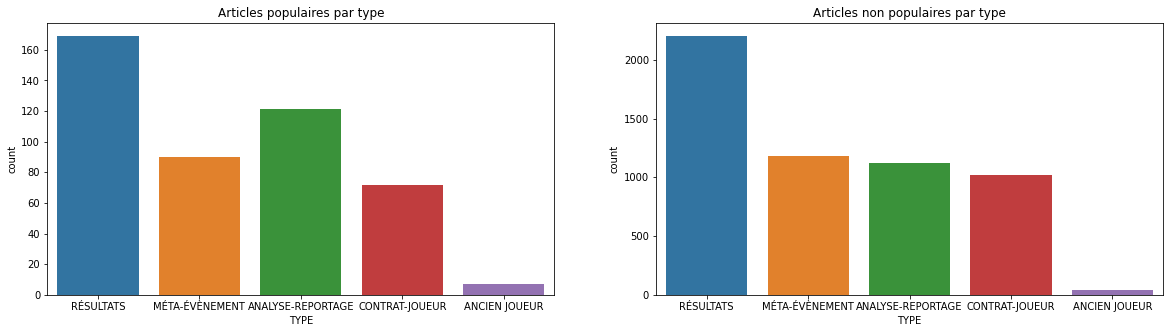

In [21]:
#Représentation graphique de répartition des types d'articles
categories = ["RÉSULTATS", 
              "MÉTA-ÉVÈNEMENT", 
              "ANALYSE-REPORTAGE" , 
              "CONTRAT-JOUEUR", 
              "ANCIEN JOUEUR"]
fig, ax =plt.subplots(1,2, figsize=[20,5])
sns.countplot(x="TYPE", data=merged[merged.top100 == 1], ax=ax[0], order= categories).set_title('Articles populaires par type')
sns.countplot(x="TYPE", data=merged[merged.top100 == 0], ax=ax[1], order= categories ).set_title('Articles non populaires par type')
fig.show()

In [ ]:
#Sports inclus dans les données
TopSports_by_count = [key for key in articles_df.Index.value_counts().keys() if key in TopSports]
TopSports_by_count

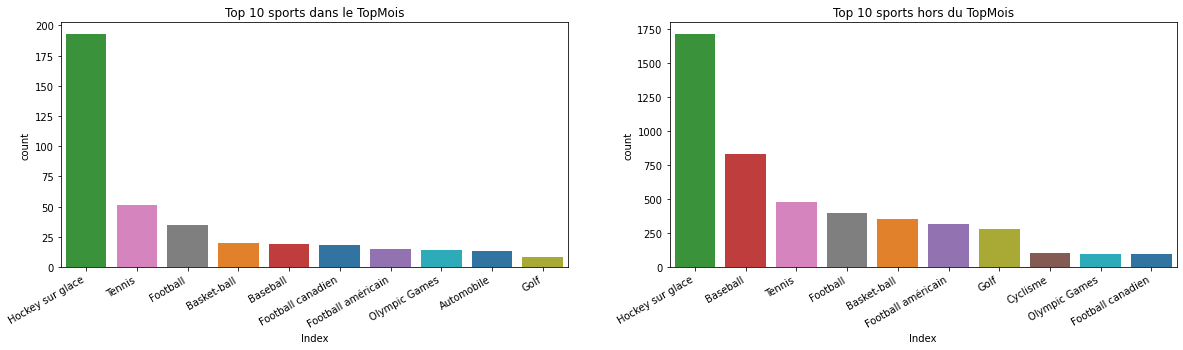

In [25]:
#Analyses des articles populaires et ordinaires par sport

palette = sns.color_palette(n_colors=len(TopSports))
color_dict = dict(zip(TopSports,palette))

#Représentation graphique de répartition des pour les 10 sports les plus fréquents

fig, ax =plt.subplots(1,2, figsize=[20,5])
fig.autofmt_xdate()
sns.countplot(x="Index", data=articles_df[articles_df.TopMois == 1], ax=ax[0],
              order=top10_sports_TM1.keys(),
              palette=color_dict ).set_title('Top 10 sports dans le TopMois')
sns.countplot(x="Index", data=articles_df[articles_df.TopMois == 0], ax=ax[1],
              order=top10_sports_TM0.keys(),
              palette=color_dict).set_title('Top 10 sports hors du TopMois')
fig.show()

Text(0.5, 1.0, 'Ratio de présence dans le TopMois / articles écrits par sport')

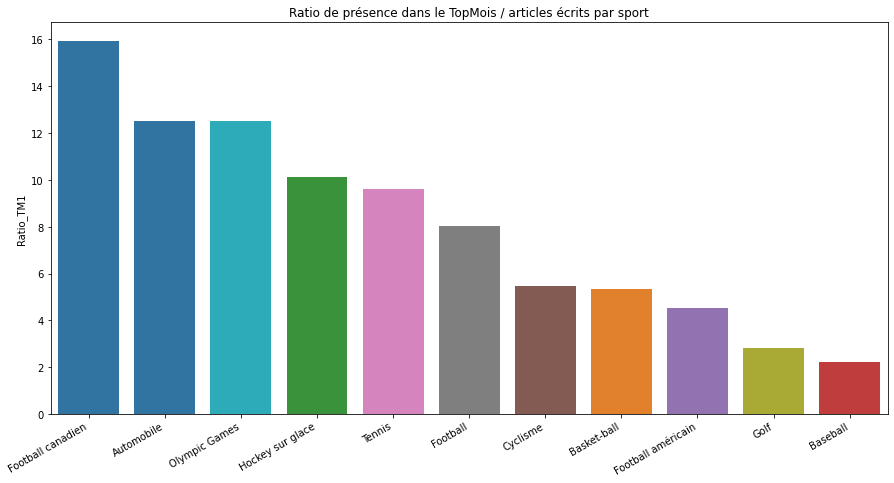

In [26]:
#Ratio de TopMois par Sport 
TopSports_counts = pd.DataFrame({ 'Top 10 sports dans TopMois' : articles_df[(articles_df.TopMois == 1) & (articles_df.Index.isin(TopSports)) ].Index.value_counts(),
 'Top 10 sports hors TopMois' : articles_df[(articles_df.TopMois == 0) & (articles_df.Index.isin(TopSports))].Index.value_counts()})
TopSports_counts['Total'] = TopSports_counts['Top 10 sports dans TopMois'] + TopSports_counts['Top 10 sports hors TopMois']
TopSports_counts['Ratio_TM1'] = 100*(TopSports_counts['Top 10 sports dans TopMois']/TopSports_counts['Total'])
TopSports_counts.sort_values(by='Ratio_TM1', ascending=False, inplace=True)
fig, ax =plt.subplots(1, figsize=[15,8])
fig.autofmt_xdate()
sns.barplot(x=TopSports_counts.index, y='Ratio_TM1',
            data=TopSports_counts,
            palette=color_dict,
            order=TopSports_counts.index ).set_title('Ratio de présence dans le TopMois / articles écrits par sport')

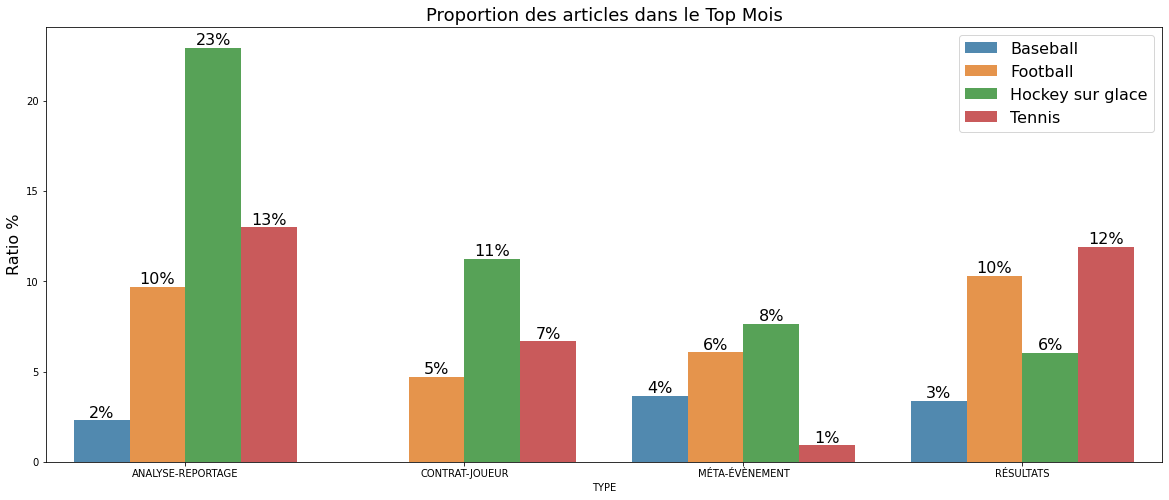

In [33]:
#Représenter les meilleurs articles par sport et par type d'articles

#Déterminer la proportion d'articles repris par type d'articles pour les 4 sports principaux
LPC_ratios = articles_df[articles_df.Index.isin(['Hockey sur glace', 'Baseball', 'Tennis', 'Football'])]\
.pivot_table(index=['TYPE','Index'], values='ID unique', columns='TopMois', aggfunc='count').reset_index()
LPC_ratios = LPC_ratios

LPC_ratios['ratios_reprise'] = LPC_ratios.apply(lambda x: 100*x[3]/(x[2]+x[3]) if not np.isnan(x[3]) else 0, axis = 1)

LPC_ratios.rename(columns={0:'TopMois0', 1:'TopMois1'}, inplace=True)

LPC_ratios.TopMois1.fillna(0, inplace=True)

LPC_ratios['total'] = LPC_ratios.TopMois0+LPC_ratios.TopMois1

#Représentation graphique
plt.figure(figsize=(20, 8))
fg  = sns.barplot(data=LPC_ratios[LPC_ratios.TYPE != 'ANCIEN JOUEUR'], x='TYPE', y='ratios_reprise', hue='Index', alpha =0.85)
for c  in fg.containers:
  plt.bar_label(c, size=16, labels=[('%.0f' % e)+'%' if (e >0) else '' for e in c.datavalues ])
plt.title('Proportion des articles dans le Top Mois', fontsize=18)
plt.ylabel('Ratio %', fontsize=16)
plt.legend(fontsize=16)

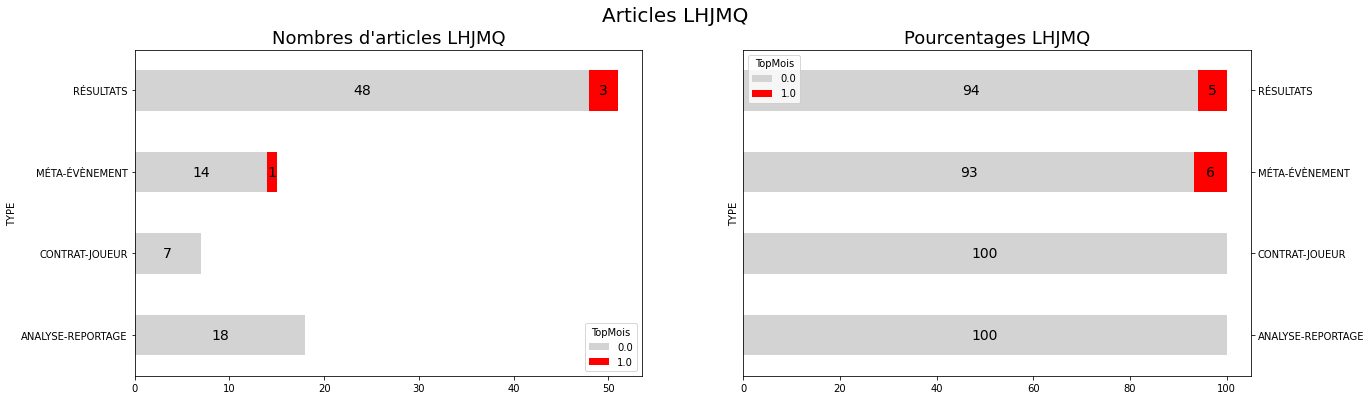

In [35]:
#Analyse de ligue de hockey majeur du québec
lhjmq = articles_df[articles_df['Titre de rappel'].str.contains('LHJMQ').fillna(False)]\
        .groupby(['TopMois','TYPE']).count().iloc[:,0].reset_index()\
        .rename(columns={'ID unique' : 'COUNT'})

def f(x):
  x['RATIO'] = round(100*x.COUNT/x.COUNT.sum(),2)
  return x

art_LHJMQ = lhjmq.groupby('TYPE').apply(f).pivot(index='TYPE', columns='TopMois', values=['COUNT','RATIO'])

#Représentation graphique
fig, ax =plt.subplots(1,2, figsize=[20,6])
fig.suptitle('Articles LHJMQ', fontsize=20)

ax[0] = art_LHJMQ['COUNT'].plot.barh(stacked=True, color={0:'lightgrey',1:'red'}, ax=ax[0])
ax[0].bar_label(ax[0].containers[0],labels=art_LHJMQ['COUNT'][0].astype(int), label_type='center',fontsize=14)
ax[0].bar_label(ax[0].containers[1], labels=art_LHJMQ['COUNT'][1].apply(lambda x: int(x) if x >0 else ''),label_type='center',fontsize=14)
ax[0].set_title('Nombres d\'articles LHJMQ', fontsize=18)

ax[1] = art_LHJMQ['RATIO'].plot.barh(stacked=True, color={0:'lightgrey',1:'red'}, ax=ax[1])
ax[1].bar_label(ax[1].containers[0],labels=art_LHJMQ['RATIO'][0].astype(int), label_type='center',fontsize=14)
ax[1].bar_label(ax[1].containers[1], labels=art_LHJMQ['RATIO'][1].apply(lambda x: int(x) if x >0 else ''),label_type='center', fontsize=14 )
#ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].set_title('Pourcentages LHJMQ', fontsize=18)
fig.show()

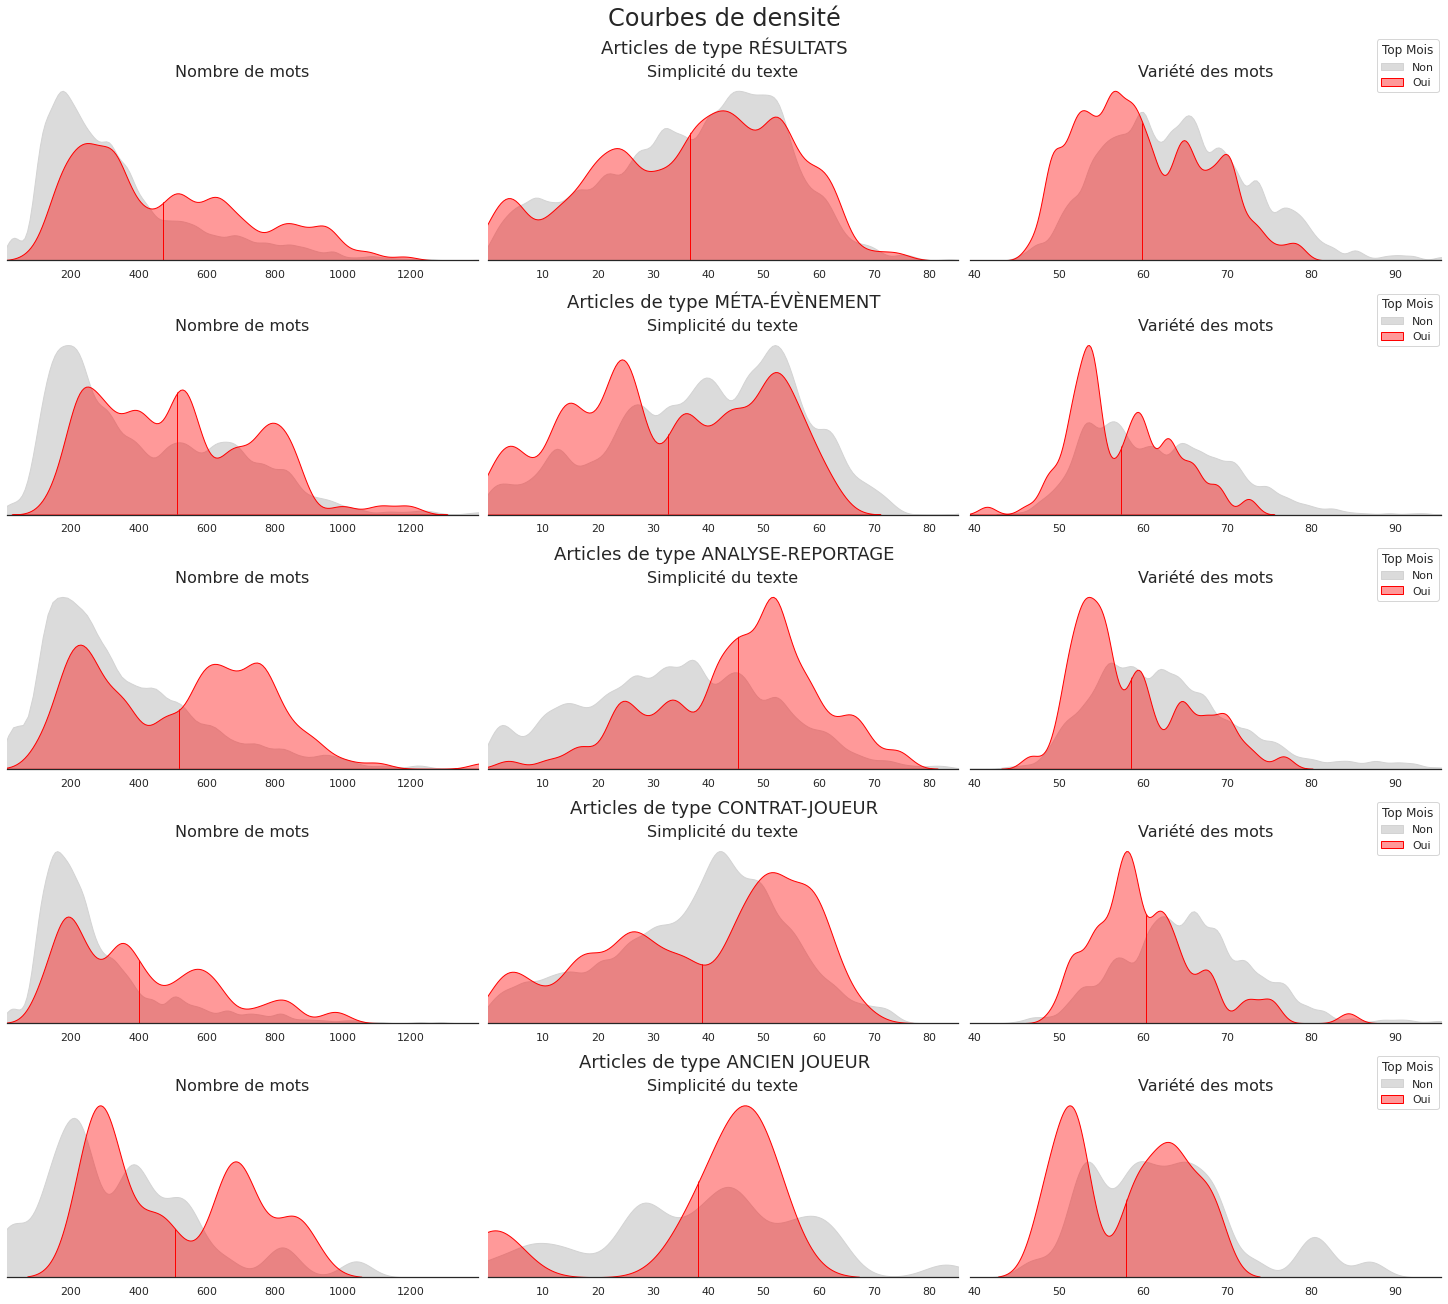

In [52]:
#Distribution des différentes variables selon le type d'articles
%%capture --no-display
#Graphique des densités par type d'article
sns.set(style="white")

metriques = ['Nombre de mots','simplicité','variété']
types_articles = articles_df.TYPE.unique()
dict_metriques = dict(zip(metriques,['Nombre de mots','Simplicité du texte', 'Variété des mots'])) 

fig = plt.figure(constrained_layout=True,figsize=[20,18])
fig.suptitle('Courbes de densité', fontsize=24)
subfigs = fig.subfigures(nrows=len(types_articles), ncols=1)

for row,(subfig,type_art) in enumerate(zip(subfigs,types_articles)):
  axes = subfig.subplots(nrows=1, ncols=3)
  for i,stat in enumerate(['Nombre de mots','simplicité','variété']):
    sns.despine(left=True)

    moyenne = articles_df[(articles_df.TopMois == 1) & (articles_df.TYPE == type_art) & (articles_df[stat]>0)][stat].mean()
    std = articles_df[(articles_df.TopMois == 1) & (articles_df[stat]>0)][stat].std()

    a=sns.kdeplot(data=articles_df[(articles_df.TopMois == 0) & (articles_df.TYPE == type_art) & (articles_df[stat]>0)],
                x=stat, fill=True, ax=axes[i], alpha=0.8, color='lightgrey', bw_adjust=0.4, common_norm=True)
    b=sns.kdeplot(data=articles_df[(articles_df.TopMois == 1) & (articles_df.TYPE == type_art)& (articles_df[stat]>0)],
                x=stat,fill=True, ax=axes[i], alpha=0.4, color='red', bw_adjust=0.4, common_norm=True)
    
    # ajoute une ligne pour la moyenne de TopMois , de façon à ce qu'elle soit coupée par la courbe de densité
    q, = b._children[1].get_paths()
    pp = mpatches.PathPatch(q, fc='none', zorder=-5)
    axes[i].add_patch(pp)
    lmoy = axes[i].axvline(moyenne, 0,1, color='red', ls='-', lw='1')
    lmoy.set_clip_path(pp)

    axes[i].set(yticklabels=[], ylabel=None, xlabel=None,
                xlim=(articles_df[articles_df[stat]>0][stat].quantile(0.0001),articles_df[articles_df[stat]>0][stat].quantile(0.999)))
    axes[i].set_title(f'{dict_metriques[stat]}', fontsize=16)
  subfig.suptitle(f'Articles de type {type_art}', fontsize=18)
  subfig.legend([0,1], labels=['Non','Oui'], title='Top Mois')

fig.show()

# Analyses descriptives

## Taille du texte

Text(0.5, 1.0, 'Nombre de mots selon TopMois')

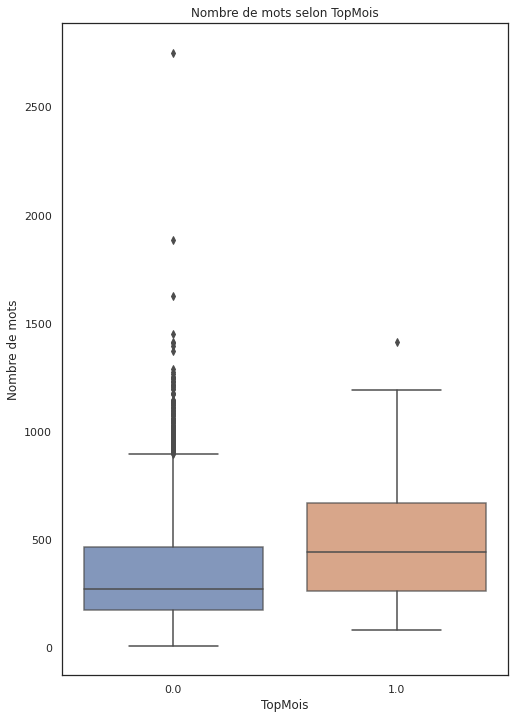

In [53]:
#Comparer le nombre de mots du top 100 vs pas le top 100
#Boxplot
fig, ax =plt.subplots(1, figsize=[8,12])
sns.boxplot(x='TopMois', y='Nombre de mots', data=articles_df, boxprops=dict(alpha=.75)).set_title('Nombre de mots selon TopMois')

In [11]:
nb_mots_in = articles_df[articles_df.TopMois == 1]['Nombre de mots'].dropna()
nb_mots_out = articles_df[articles_df.TopMois == 0]['Nombre de mots'].dropna()

# test de Levene
lev_stat, lev_p = stats.levene(nb_mots_in, nb_mots_out )
print(f"Avec une statistique de {lev_stat:.2f} et une p-value : {lev_p:.2g} nous pouvons rejeter l'hypothèse d'égalité des variances \n et utiliser le test de Welch " )

# test t
t_stat, t_p = stats.ttest_ind(nb_mots_in, nb_mots_out, equal_var=False, alternative='greater' )
print(f"Avec une statistique de {t_stat:.2f} et une p-value : {t_p:.2g} nous pouvons rejeter l'hypothèse d'égalité des moyennes \n et confirmer qu'en moyenne les articles du top 100 sont plus longs " )

Avec une statistique de 21.10 et une p-value : 4.5e-06 nous pouvons rejeter l'hypothèse d'égalité des variances 
 et utiliser le test de Welch 
Avec une statistique de 11.22 et une p-value : 1.3e-26 nous pouvons rejeter l'hypothèse d'égalité des moyennes 
 et confirmer qu'en moyenne les articles du top 100 sont plus longs 


In [14]:
pg.ttest(nb_mots_in, nb_mots_out, correction=True, alternative='greater').drop(columns=['BF10','alternative']).round(2)

,T,dof,p-val,CI95%,cohen-d,power
T-test,11.22,524.38,0.0,"[115.53, inf]",0.58,1.0


In [15]:
#Vérifier les moyennes du nombre de mots par catégories
dict_lpc = {'Moyenne_Top100' : articles_df[articles_df.TopMois == 1].groupby('TYPE')['Nombre de mots'].mean(),
    'Var_Top100' : articles_df[articles_df.TopMois == 1].groupby('TYPE')['Nombre de mots'].var().round(decimals =2),
    'Moyenne_hors_Top100' : articles_df[articles_df.TopMois == 0].groupby('TYPE')['Nombre de mots'].mean(),
    'Var_hors_Top100' : articles_df[articles_df.TopMois == 0].groupby('TYPE')['Nombre de mots'].var().round(decimals =2)}

#Transformer en dataframe
vc = pd.DataFrame(dict_lpc)
vc 

,Moyenne_Top100,Var_Top100,Moyenne_hors_Top100,Var_hors_Top100
TYPE,,,,
ANALYSE-REPORTAGE,519.504132,67208.29,355.234194,61397.64
ANCIEN JOUEUR,506.428571,56523.62,351.000000,54786.57
CONTRAT-JOUEUR,401.625000,49232.66,277.186759,34957.05
MÉTA-ÉVÈNEMENT,513.055556,55232.08,419.078498,66772.20
RÉSULTATS,472.485030,64880.52,336.049658,48712.68


Text(0.5, 1.0, 'Nombre de mots selon la popularité des articles et leur type')

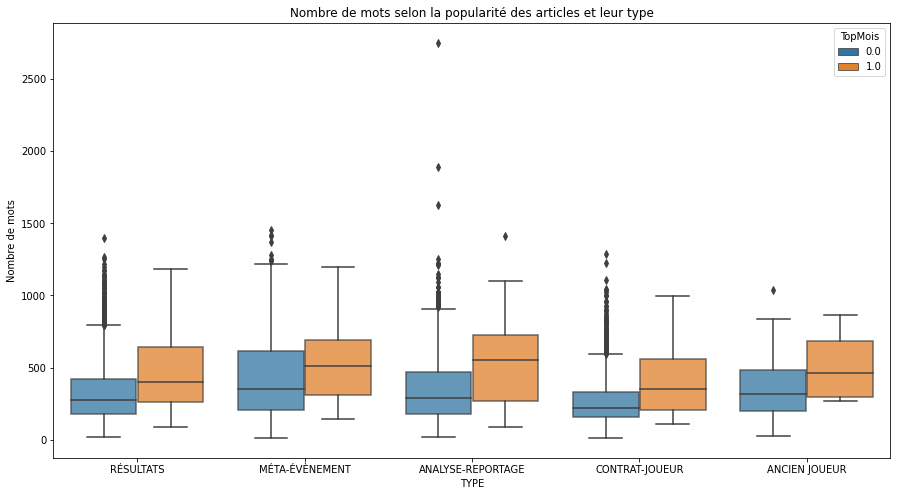

In [44]:
#représentation graphique du nombre de mots par types d'articles dans top100
plt.figure(figsize=(15,8))
fig.autofmt_xdate()
sns.boxplot(x='TYPE', y='Nombre de mots', hue='TopMois', data=articles_df, boxprops=dict(alpha=.75)).set_title('Nombre de mots selon la popularité des articles et leur type')

In [38]:
paired_ttests = pd.DataFrame(columns=['T', 'dof', 'alternative', 'p-val', 'CI95%', 'cohen-d', 'BF10',
       'power'])
for type_art in categories:
  type_topmois1 = articles_df[(articles_df.TopMois == 1) & (articles_df.TYPE == type_art)].dropna(subset=["Nombre de mots"])['Nombre de mots']
  type_topmois0 = articles_df[(articles_df.TopMois ==0) & (articles_df.TYPE == type_art)].dropna(subset=["Nombre de mots"])['Nombre de mots']
  ttest_t = pg.ttest(type_topmois1, type_topmois0)
  ttest_t.index = [type_art]
  paired_ttests = paired_ttests.append(ttest_t)
paired_ttests.round(4).drop(columns=['alternative', 'BF10'])

,T,dof,p-val,CI95%,cohen-d,power
RÉSULTATS,6.7323,185.4607,0.0000,"[96.45, 176.42]",0.6111,1.0000
MÉTA-ÉVÈNEMENT,3.6289,106.2224,0.0004,"[42.63, 145.32]",0.3659,0.9166
ANALYSE-REPORTAGE,6.6505,144.6364,0.0000,"[115.45, 213.09]",0.6599,1.0000
CONTRAT-JOUEUR,4.6429,78.3405,0.0000,"[71.08, 177.79]",0.6568,0.9997
ANCIEN JOUEUR,1.5866,8.4235,0.1494,"[-68.51, 379.37]",0.6625,0.3471


Text(0.5, 1.0, 'Nombre de mots selon le sport et la popularité des articles')

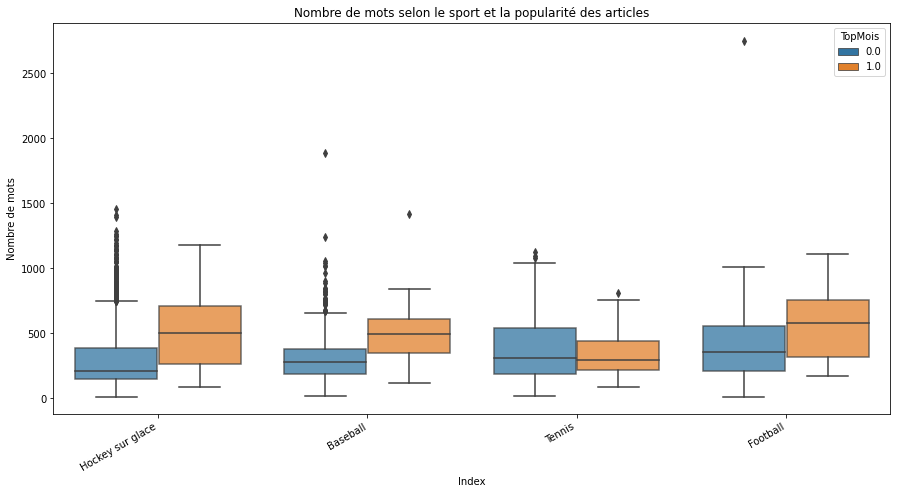

In [59]:
#représentation graphique du nombre de mots par sport dans top100
fig,ax = plt.subplots(1,1,figsize=[15,8])
fig.autofmt_xdate()
sns.boxplot(x='Index', y='Nombre de mots', hue='TopMois', order = ['Hockey sur glace', 'Baseball', 'Tennis', 'Football'] , data=articles_df, boxprops=dict(alpha=.75)).set_title('Nombre de mots selon le sport et la popularité des articles')

In [37]:
paired_ttests = pd.DataFrame(columns=['T', 'dof', 'alternative', 'p-val', 'CI95%', 'cohen-d', 'BF10',
       'power'])
for sport in ['Hockey sur glace', 'Baseball', 'Tennis', 'Football']:
  type_topmois1 = articles_df[(articles_df.TopMois == 1) & (articles_df.Index == sport) ].dropna(subset=["Nombre de mots"])['Nombre de mots']
  type_topmois0 = articles_df[(articles_df.TopMois ==0) & (articles_df.Index == sport)].dropna(subset=["Nombre de mots"])['Nombre de mots']
  ttest_t = pg.ttest(type_topmois1, type_topmois0)
  ttest_t.index = [sport]
  paired_ttests = paired_ttests.append(ttest_t)
paired_ttests.round(4).drop(columns=['alternative', 'BF10'])

,T,dof,p-val,CI95%,cohen-d,power
Hockey sur glace,9.8208,228.9615,0.0000,"[157.41, 236.43]",0.8061,1.0000
Baseball,3.0051,18.3053,0.0075,"[60.39, 339.88]",1.1165,0.9978
Tennis,-1.6787,79.3184,0.0971,"[-92.22, 7.83]",0.1728,0.2159
Football,3.6366,40.4317,0.0008,"[71.75, 251.14]",0.6302,0.9460


## Simplicité du texte

Text(0.5, 1.0, 'Score de simplicité selon la popularité des articles et leur type')

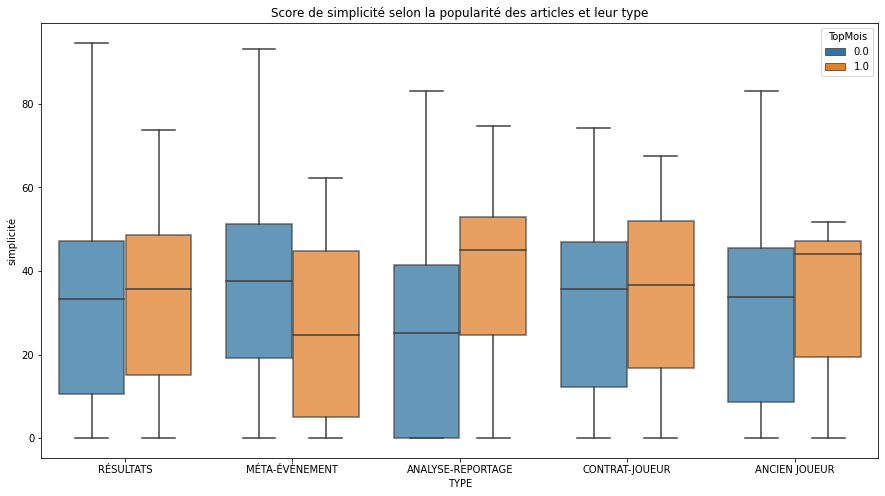

In [58]:
#représentation graphique du score de simplicité par types d'articles dans top100
plt.figure(figsize=(15,8))
fig.autofmt_xdate()
sns.boxplot(x='TYPE', y='simplicité', hue='TopMois', data=articles_df, boxprops=dict(alpha=.75)).set_title('Score de simplicité selon la popularité des articles et leur type')

In [64]:
paired_ttests = pd.DataFrame(columns=['T', 'dof', 'alternative', 'p-val', 'CI95%', 'cohen-d', 'BF10',
       'power'])
for type_art in categories:
  type_topmois1 = articles_df[(articles_df.TopMois == 1) & (articles_df.TYPE == type_art) & (articles_df.simplicité >0)].dropna(subset=["simplicité"])['simplicité']
  type_topmois0 = articles_df[(articles_df.TopMois ==0) & (articles_df.TYPE == type_art) & (articles_df.simplicité >0)].dropna(subset=["simplicité"])['simplicité']
  ttest_t = pg.ttest(type_topmois1, type_topmois0)
  ttest_t.index = [type_art]
  paired_ttests = paired_ttests.append(ttest_t)
paired_ttests.round(4).drop(columns=['alternative', 'BF10'])

,T,dof,p-val,CI95%,cohen-d,power
RÉSULTATS,-0.2841,166.5381,0.7767,"[-3.35, 2.51]",0.0258,0.0603
MÉTA-ÉVÈNEMENT,-3.2710,80.7259,0.0016,"[-11.09, -2.7]",0.4089,0.9178
ANALYSE-REPORTAGE,7.3539,138.3237,0.0000,"[8.31, 14.43]",0.6829,1.0000
CONTRAT-JOUEUR,0.4668,69.3160,0.6421,"[-3.6, 5.81]",0.0686,0.0821
ANCIEN JOUEUR,-0.0667,7.2481,0.9486,"[-20.17, 19.05]",0.0294,0.0505


Text(0.5, 1.0, 'Score de simplicité selon le sport et la popularité des articles')

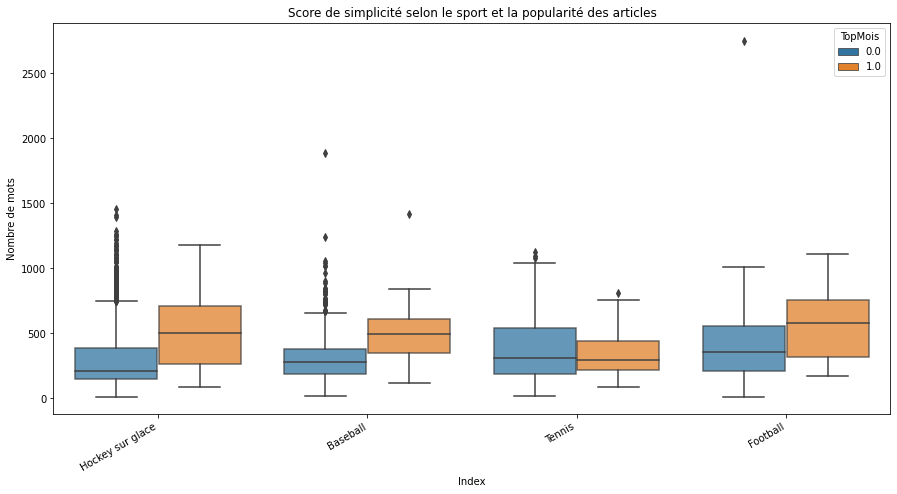

In [60]:
#représentation graphique du score de simplicité par sport dans topMois
fig,ax = plt.subplots(1,1,figsize=[15,8])
fig.autofmt_xdate()
sns.boxplot(x='Index', y='Nombre de mots', hue='TopMois', order = ['Hockey sur glace', 'Baseball', 'Tennis', 'Football'] , data=articles_df, boxprops=dict(alpha=.75)).set_title('Score de simplicité selon le sport et la popularité des articles')

In [66]:
paired_ttests = pd.DataFrame(columns=['T', 'dof', 'alternative', 'p-val', 'CI95%', 'cohen-d', 'BF10',
       'power'])
for sport in ['Hockey sur glace', 'Baseball', 'Tennis', 'Football','Golf'] :
  type_topmois1 = articles_df[(articles_df.TopMois == 1) & (articles_df.Index == sport) & (articles_df.simplicité >0)].dropna(subset=["simplicité"])['simplicité']
  type_topmois0 = articles_df[(articles_df.TopMois ==0) & (articles_df.Index == sport) & (articles_df.simplicité >0)].dropna(subset=["simplicité"])['simplicité']
  ttest_t = pg.ttest(type_topmois1, type_topmois0)
  ttest_t.index = [sport]
  paired_ttests = paired_ttests.append(ttest_t)
paired_ttests.round(4).drop(columns=['alternative', 'BF10'])

,T,dof,p-val,CI95%,cohen-d,power
Hockey sur glace,3.0082,212.7262,0.0029,"[1.37, 6.59]",0.2443,0.8491
Baseball,2.4529,15.8685,0.0261,"[1.21, 16.76]",0.5624,0.6029
Tennis,-1.3548,46.8373,0.1820,"[-9.07, 1.77]",0.2302,0.2826
Football,0.9803,37.2967,0.3333,"[-3.23, 9.29]",0.1840,0.1675
Golf,-4.1158,5.3637,0.0079,"[-32.28, -7.77]",1.4143,0.9265


## Variété du vocabulaire

Text(0.5, 1.0, "Variété des mots selon le type d'article et la popularité des articles")

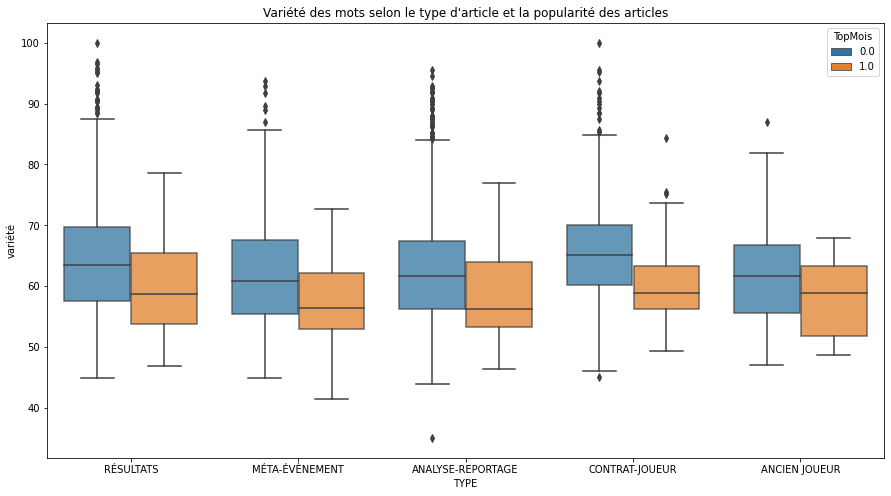

In [68]:
#représentation graphique du score de variété par type d'articles dans topMois
plt.figure(figsize=(15,8))
fig.autofmt_xdate()
sns.boxplot(x='TYPE', y='variété', hue='TopMois', data=articles_df, boxprops=dict(alpha=.75)).set_title('Variété des mots selon le type d\'article et la popularité des articles')

Text(0.5, 1.0, 'Variété des mots selon le sport et la popularité des articles')

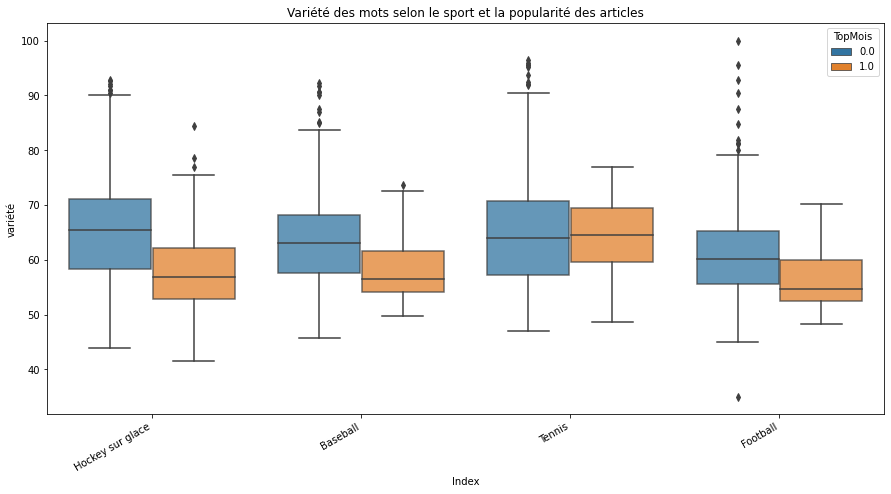

In [69]:
#représentation graphique du score de variété par sport dans topMois
fig,ax = plt.subplots(1,1,figsize=[15,8])
fig.autofmt_xdate()
sns.boxplot(x='Index', y='variété', hue='TopMois', order = ['Hockey sur glace', 'Baseball', 'Tennis', 'Football'] , data=articles_df, boxprops=dict(alpha=.75)).set_title('Variété des mots selon le sport et la popularité des articles')

In [70]:
paired_ttests = pd.DataFrame(columns=['T', 'dof', 'alternative', 'p-val', 'CI95%', 'cohen-d', 'BF10',
       'power'])
for sport in ['Hockey sur glace', 'Baseball', 'Tennis', 'Football']:
  type_topmois1 = articles_df[(articles_df.TopMois == 1) & (articles_df.Index == sport)].dropna(subset=["variété"])['variété']
  type_topmois0 = articles_df[(articles_df.TopMois ==0) & (articles_df.Index == sport) ].dropna(subset=["variété"])['variété']
  ttest_t = pg.ttest(type_topmois1, type_topmois0)
  ttest_t.index = [sport]
  paired_ttests = paired_ttests.append(ttest_t)
paired_ttests.round(4).drop(columns=['alternative', 'BF10'])

,T,dof,p-val,CI95%,cohen-d,power
Hockey sur glace,-12.7390,265.6111,0.0000,"[-8.08, -5.91]",0.8059,1.0000
Baseball,-2.9774,19.0294,0.0077,"[-8.22, -1.43]",0.6234,0.7654
Tennis,-0.7107,79.2834,0.4793,"[-2.61, 1.24]",0.0732,0.0786
Football,-4.1095,45.3073,0.0002,"[-6.8, -2.33]",0.5692,0.8966


## Analyse de similarité des articles

In [72]:
#Fonction pour faire du nettoyage de texte
def preprocess(text):
  import nltk
  import string
  !pip install git+https://github.com/ClaudeCoulombe/FrenchLefffLemmatizer.git
  from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer
  nltk.download('wordnet')
  nltk.download('punkt')
  nltk.download('stopwords')
  french_stopwords = nltk.corpus.stopwords.words('french')
  lemmatizer = FrenchLefffLemmatizer()
  
  preprocess_list = []
  for sentence in text :
    sentence_w_punct = "".join([i.lower() for i in sentence if i not in string.punctuation]) #Enlever la ponctuation
    sentence_w_num = ''.join(i for i in sentence_w_punct if not i.isdigit()) #Enlever les chiffres
    tokenize_sentence = nltk.tokenize.word_tokenize(sentence_w_num) #Transformer les phrases en liste de tokens 
    words_w_stopwords = [i for i in tokenize_sentence if i not in french_stopwords] #Enlever les stopwords
    words_lemmatize = (lemmatizer.lemmatize(w) for w in words_w_stopwords) #lemmatizer
    sentence_clean = ' '.join(w for w in words_lemmatize) #Relier la phrase
    preprocess_list.append(sentence_clean)

  return preprocess_list


In [73]:
articles_df["texte"] = preprocess(articles_df["texte_original_sd"])

  Cloning https://github.com/ClaudeCoulombe/FrenchLefffLemmatizer.git to /tmp/pip-req-build-hq6peu_p
  Running command git clone -q https://github.com/ClaudeCoulombe/FrenchLefffLemmatizer.git /tmp/pip-req-build-hq6peu_p
  Created wheel for FrenchLefffLemmatizer: filename=FrenchLefffLemmatizer-0.3-py3-none-any.whl size=3533529 sha256=24e2ed2e2d4e20e68c1a9e040f622a4a7b0785a26258697f3df5090baaa01bcd
  Stored in directory: /tmp/pip-ephem-wheel-cache-9bq6gfhk/wheels/ba/24/e1/a774b7bba29a14b3f6b291d16e92563c745aa4f4d6901a0af7
Successfully built FrenchLefffLemmatizer
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [74]:
#Fonction pour calculer le score de similarité par sport 
def similarity(sport):  
  # Scikit Learn
  from sklearn.feature_extraction.text import TfidfVectorizer
  from sklearn.metrics.pairwise import cosine_similarity

  df = articles_df[articles_df['Index'].str.contains(f"{sport}", na=False)]
  # Create the Document Term Matrix
  v = TfidfVectorizer()
  x = v.fit_transform(df["texte"])

  # OPTIONAL: Convert Sparse Matrix to Pandas Dataframe if you want to see the word frequencies.
  doc_term_matrix = x.todense()
  df_tfidf = pd.DataFrame(doc_term_matrix, 
                    columns=v.get_feature_names(), 
                    index=df.titre_original_sd)
  #Transformer la matrice des distances cosine qui compare les documents 2 par 2 en base de données
  df_cosine = pd.DataFrame(cosine_similarity(df_tfidf, df_tfidf), 
                    columns=df.titre_original_sd, 
                    index=df.titre_original_sd)
  df_cosine['Sim_tot'] = df_cosine.sum(axis=1) 
  df_fin = df_cosine[['Sim_tot']]

  #Rajouter la variable similarité par rapport à la totalité du corpus
  articles_simcorpus = pd.merge(df, df_fin, how = 'inner', left_on='titre_original_sd', right_on=df_fin.index)

  return articles_simcorpus

### Hockey

In [76]:
hockey = similarity('Hockey sur glace')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


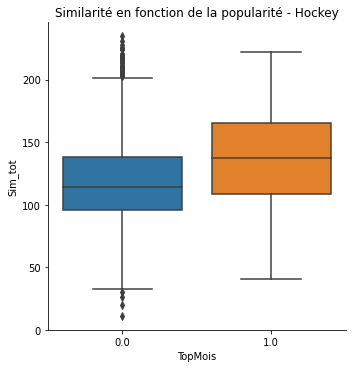

In [80]:
#Checker distribution du score de complexité sur le corpus par rapport au nombre de reprises
sns.catplot(x="TopMois", y="Sim_tot", kind="box", data=hockey).set(title='Similarité en fonction de la popularité - Hockey')

In [81]:
#Tester homogeneité des variances
import scipy.stats as stats
stats.levene(hockey['Sim_tot'][hockey['TopMois'] == 0],
             hockey['Sim_tot'][hockey['TopMois'] == 1],
             center= 'mean')
#Les variances ne sont pas égales

LeveneResult(statistic=6.896813376743193, pvalue=0.00870400695608621)

In [83]:
pg.ttest(hockey['Sim_tot'][hockey['TopMois'] == 1], hockey['Sim_tot'][hockey['TopMois'] == 0], correction=True, alternative='greater').drop(columns=['BF10','alternative']).round(6)

,T,dof,p-val,CI95%,cohen-d,power
T-test,6.414645,231.218688,0.0,"[14.24, inf]",0.526811,1.0


### Tennis

In [88]:
tennis = similarity('Tennis')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


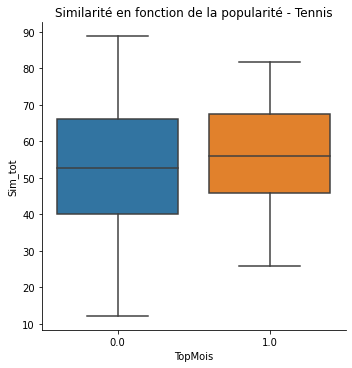

In [89]:
#Checker distribution du score de complexité sur le corpus par rapport au nombre de reprises
sns.catplot(x="TopMois", y="Sim_tot", kind="box", data=tennis).set(title='Similarité en fonction de la popularité - Tennis')

In [90]:
#Tester homogeneité des variances
stats.levene(tennis['Sim_tot'][tennis['TopMois'] == 0],
             tennis['Sim_tot'][tennis['TopMois'] == 1],
             center= 'mean')
#Les variances ne sont pas égales

LeveneResult(statistic=5.049774401471886, pvalue=0.025041325496057983)

In [91]:
#Test de welch
pg.ttest(tennis['Sim_tot'][tennis['TopMois'] == 1], tennis['Sim_tot'][tennis['TopMois'] == 0], correction=True, alternative='greater').drop(columns=['BF10','alternative']).round(2)
#Différence statistiquement significative

,T,dof,p-val,CI95%,cohen-d,power
T-test,2.11,67.87,0.02,"[0.9, inf]",0.26,0.54


### Football

In [ ]:
football = similarity('Football')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


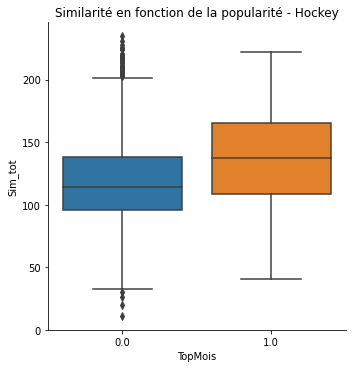

In [ ]:
#Checker distribution du score de complexité sur le corpus par rapport au nombre de reprises
sns.catplot(x="TopMois", y="Sim_tot", kind="box", data=football).set(title='Similarité en fonction de la popularité - Football')

In [ ]:
#Tester homogeneité des variances
stats.levene(football['Sim_tot'][football['TopMois'] == 0],
             football['Sim_tot'][football['TopMois'] == 1],
             center= 'mean')
#Les variances sont égales

LeveneResult(statistic=6.896813376743193, pvalue=0.00870400695608621)

In [ ]:
#ttest normal
pg.ttest(football['Sim_tot'][football['TopMois'] == 1], football['Sim_tot'][football['TopMois'] == 0], correction=False, alternative='greater').drop(columns=['BF10','alternative']).round(16)
#Différence statistiquement significative

,T,dof,p-val,CI95%,cohen-d,power
T-test,6.414645,231.218688,0.0,"[14.24, inf]",0.526811,1.0


### Baseball

In [93]:
baseball = similarity('Baseball')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


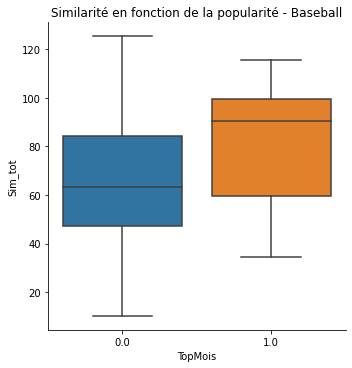

In [94]:
#Checker distribution du score de complexité sur le corpus par rapport au nombre de reprises
sns.catplot(x="TopMois", y="Sim_tot", kind="box", data=baseball).set(title='Similarité en fonction de la popularité - Baseball')

In [95]:
#Tester homogeneité des variances
stats.levene(baseball['Sim_tot'][baseball['TopMois'] == 0],
             baseball['Sim_tot'][baseball['TopMois'] == 1],
             center= 'mean')
#Les variances sont égales

LeveneResult(statistic=0.5212282638371177, pvalue=0.4705163012534054)

In [96]:
#ttest normal
pg.ttest(baseball['Sim_tot'][baseball['TopMois'] == 1], baseball['Sim_tot'][baseball['TopMois'] == 0], correction=False, alternative='greater').drop(columns=['BF10','alternative']).round(6)
#Différence statistiquement significative

,T,dof,p-val,CI95%,cohen-d,power
T-test,2.876766,852,0.002059,"[6.74, inf]",0.667442,0.890582


## Analyses avec Google Trends

In [ ]:
#Nettoyage du fichier contenant les articles et les trends
def GetGGTrends(df):

  dg = df.copy()

  #Enlever les colonnes inutiles
  dg.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0_x', 'index_x', "Abonnés cibles", "Avis de droit d'auteur", "Conditions d'utilisation", 
                   "Estampille d'embargo", "Expiration", "Fournisseur d'ingestion", "Fuseau horaire", "GUID", "ID unique",
                   "Identification originale", "Initiales", "Langue", "Lead", "Mots-clés", "Note de la rédaction", "Origine et date", "Priorité", "Ranking", "Signature",
                   "Statut de publication", "Séquence de fournisseur d'ingestion", "Type", "Version", "Wire", "État", "Langue Origine", "titre_x", "texte_x", "level_0", "index_y",
                   "titre_y", "date", "date", "texte_y", "Jour", "titre_full", "texte_full", "titre_y.1", "reprises", "N_TYPE", "N_MOIS", "texte_50pct", "Unnamed: 0_y", "Auteur original",
                   "Créateur de la version", "Détenteur du droit d'auteur", "Source", "Endroit", "Horaire de publication", "Titre de rappel", "top100", "NbPhrases", "NbMotsComplexes",
                   "smog", "flesch", "TpsLecture", "day_of_week", "nb_unique_words", "variety", "Date_create", "texte_original_sd"], inplace=True)
  dg.rename(columns={'titre_original_sd': 'Titre', "Index" : "Sport"}, inplace=True)

  #Remplacer les valeurs nulles des sources
  dg["Source originale"].fillna(value="LPC", inplace=True)

  #Mettre les dates au bon format
  dg["MoisAnnee"] = (pd.DatetimeIndex(dg['Date_Maj']).month).astype(str) + (pd.DatetimeIndex(dg['Date_Maj']).year).astype(str)

  #Binariser les sports
  dg["LPCHockey"] = np.where(dg["Sport"] == "Hockey sur glace", 1, 0)
  dg["LPCTennis"] = np.where(dg["Sport"] == "Tennis", 1, 0)
  dg["LPCFootball"] = np.where(dg["Sport"] == "Football", 1, 0)
  dg["LPCBaseball"] = np.where(dg["Sport"] == "Baseball", 1, 0)
  dg["LPCTopHockey"] = np.where((dg["Sport"] == "Hockey sur glace") & (dg["TopMois"] > 0), 1, 0)
  dg["LPCTopTennis"] = np.where((dg["Sport"] == "Tennis") & (dg["TopMois"] > 0), 1, 0)
  dg["LPCTopFootball"] = np.where((dg["Sport"] == "Football") & (dg["TopMois"] > 0), 1, 0)
  dg["LPCTopBaseball"] = np.where((dg["Sport"] == "Baseball") & (dg["TopMois"] > 0), 1, 0)

  #Faire l'agrégation
  # dg = dg.groupby(['MoisAnnee']).agg({'LPCHockey' : 'sum', 'LPCTopHockey' : 'sum', 'LPCTennis' : 'sum', 'LPCTopTennis' : 'sum', 'LPCFootball' : 'sum', 'LPCTopFootball' : 'sum', 'LPCBaseball' : 'sum', 'LPCTopBaseball' : 'sum'}).reset_index()
  dg = dg.groupby(['MoisAnnee']).agg({'LPCTopHockey' : 'sum', 'LPCTopFootball' : 'sum', 'LPCTopTennis' : 'sum', 'LPCTopBaseball' : 'sum'}).reset_index()

  return dg

LPCT = GetGGTrends(LPC)
LPCT.head()

In [4]:
#Faire une fusion avec le fichier complet d'articles pour obtenir toutes les informations
Tendances = trends1.merge(LPCT, how='left', on="MoisAnnee")

In [5]:
#Obtenir la matrice de corrélation pour voir les corréaltion sur chaque sport
corrMatrix = Tendances.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [ ]:
#Obtenir seulement la corrélation du Hockey
def getHeatHockey(df):
  
  #Créer une copie de la bd
  dg = df.copy()

  #Enelever les colonnes inutiles
  dg = dg.drop(["Football", "Tennis", "Baseball", "LPCTopFootball", "LPCTopTennis", "LPCTopBaseball"], axis = 1)

  #Obtenir la heatmap
  corrMatrix = dg.corr()
  sns.heatmap(corrMatrix, annot=True)
  plt.show()


getHeatHockey(Tendances)

In [ ]:
#Obtenir seulement la corrélation du Tennis
def getHeatTennis(df):
  
  #Créer une copie de la bd
  dg = df.copy()

  #Enelever les colonnes inutiles
  dg = dg.drop(["Football", "Hockey", "Baseball", "LPCTopFootball", "LPCTopHockey", "LPCTopBaseball"], axis = 1)

  #Obtenir la heatmap
  corrMatrix = dg.corr()
  sns.heatmap(corrMatrix, annot=True)
  plt.show()


getHeatTennis(Tendances)

In [ ]:
#Obtenir seulement la corrélation du Baseball
def getHeatBaseball(df):
  
  #Créer une copie de la bd
  dg = df.copy()

  #Enelever les colonnes inutiles
  dg = dg.drop(["Football", "Tennis", "Hockey", "LPCTopFootball", "LPCTopTennis", "LPCTopHockey"], axis = 1)

  #Obtenir la heatmap
  corrMatrix = dg.corr()
  sns.heatmap(corrMatrix, annot=True)
  plt.show()


getHeatBaseball(Tendances)

In [ ]:
#Obtenir seulement la corrélation du Football
def getHeatFoot(df):
  
  #Créer une copie de la bd
  dg = df.copy()

  #Enelever les colonnes inutiles
  dg = dg.drop(["Hockey", "Tennis", "Baseball", "LPCTopHockey", "LPCTopTennis", "LPCTopBaseball"], axis = 1)

  #Obtenir la heatmap
  corrMatrix = dg.corr()
  sns.heatmap(corrMatrix, annot=True)
  plt.show()


getHeatFoot(Tendances)